# Web Scraping.

## Autores: Andrés Yañez, Paul Camacho 

En el presente notebook se realiza el scraping de la pagina huffpost.

* Realizar scrapping de títulos de artículos de la web en las temáticas de anteriores. Se piden más de 20 por categoría. 

Se realizo la extracción de 30 noticias por categoría.

1. Bussines
2. Sports
3. Wellness
4. Travel
5. Parent 

In [13]:
# Importamos librerias
from requests import get
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen

# Importamos librerías
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import json
import csv
import requests


In [14]:
# helpers


def hasChildrenByTag (soup: BeautifulSoup,tag = 'a'): # Permite encontrar el tag 'a' 
    return soup.find(tag)

def addToDictionary (dictionary, key, value): # Agregamos al diccionario el scrap de huffpost
  if(key in dictionary):
      dictionary[key].append(value)
  else:
      dictionary[key] = []
      dictionary[key].append(value)

def webScrappingUrl (url, page, dictionary, preDefinedCategory):  # Función para realizar el web scraping para páginas de huffpost
  url = url+str(page) # llamamos a la url
  response = get(url) 
  response.encoding = "utf-8" # encoding para que el csv sea utf-8 
  soup = BeautifulSoup(response.text, 'html.parser')
  page_content = soup.find('div', class_ = 'a-page__content a-page__content--twilight a-page__content--twilight-1') # contenido principal donde llamamos a los datos a través de nuestra función
  category = page_content.find('h2', class_ = 'zone__title__text').getText()
  cards = soup.find_all('div', class_ = 'card--standard') # las divisiones en donde se encuentran los datos a rescatar 
  for card in cards:
      name = card.find('h3', {'class': 'card__headline__text'}).getText() # Extraemos los titulos
      if len(preDefinedCategory) > 0:
        addToDictionary(dictionary, preDefinedCategory, {"name": name})  # Extraemos la categoría
      else:
        addToDictionary(dictionary, category, {"name": name})

def extractFromRequest(url, page, dictionary, preDefinedCategory): # Funciòn que realiza el request a la api de la página
  params = dict( page = page, limit = 10) # En este caso el límite de páginas es de 10 
  response = requests.get(url, params = params)
  data = response.json()
  category = data["cards"][0]["labels"]["top"]["text"] # seleccionamos la extructura de dónde extraeremos los datos 
  for card in data["cards"]:
    name = card["headlines"][0]["text"] # extraemos el título
    if len(preDefinedCategory) > 0:
      addToDictionary(dictionary, preDefinedCategory, {"name": name}) # Agregamos las categorías 
    else:
      addToDictionary(dictionary, category, {"name": name}) # Existen otras categorías en las cuales los post estan en 
                                                            # por e.g Wellness pero huffpost lo relaciona con otro topic
                                                            # por ello en ambas funciones podrá ver predefinedcategory.
  

En la siguiente imagen podrá observar de donde se llamo a la API para la segunda función, la cual almacena título, descripción, categoría 

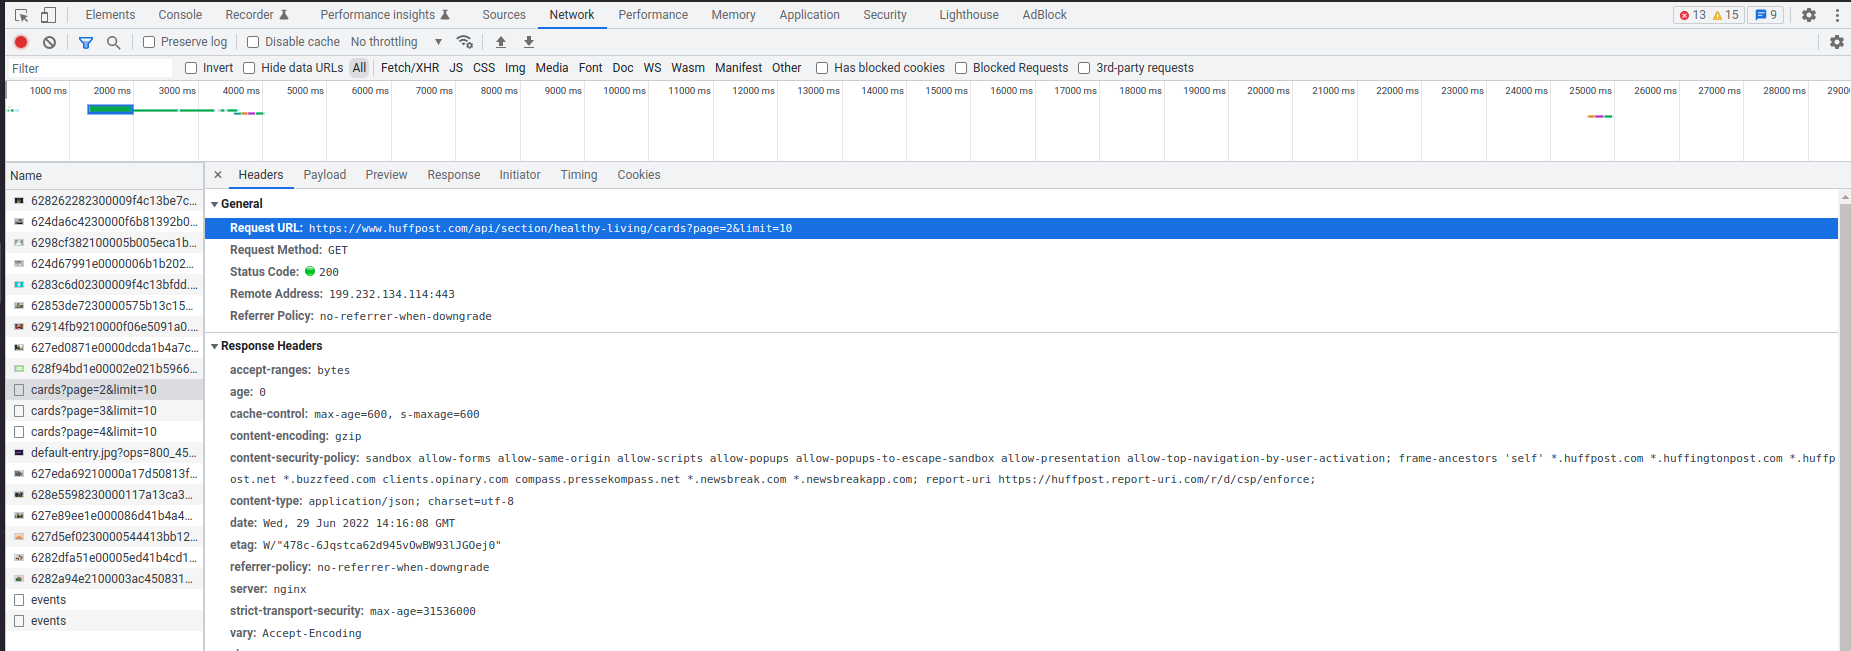

In [15]:
# Como solo necesitamos más de 20 post, extraeremos 30 por categoría
number_of_post = 30
iterations = number_of_post/10

# almacenamos todo en un diccionario para luego guardarlo
dictionary = {}
page = 1 # Empezamos por la primera página para luego iterarla 
while page <= iterations:
    webScrappingUrl("https://www.huffpost.com/impact/business?page=", page, dictionary, "")
    webScrappingUrl("https://www.huffpost.com/impact/sports?page=", page, dictionary, "")
    extractFromRequest("https://www.huffpost.com/api/section/healthy-living/cards", page, dictionary, "")
    extractFromRequest("https://www.huffpost.com/api/section/travel/cards", page, dictionary, "Travel")
    extractFromRequest("https://www.huffpost.com/api/section/parents/cards", page, dictionary, "Parent")
    page += 1
print(dictionary.keys()) # Revisamos si se han extraído de manera correcta.

dict_keys(['Business', 'Sports', 'Wellness', 'Travel', 'Parent'])


In [16]:
# Almacenamos los datos extraídos en un csv para su posterior trabajo 
csv_file = open('huffpost.csv', 'w', newline='', encoding='utf-8') 
csv_writer = csv.writer(csv_file, delimiter = ",")
count = 0
for data in dictionary:
  for element in dictionary[data]:
    if count == 0:
        csv_writer.writerow(["category", "headline"])
        count += 1
    csv_writer.writerow([data, element["name"]])
csv_file.close()